In [1]:
!tar -xvf "/content/drive/MyDrive/bayena/nn_unet_preds.tar" -C "./"   > /dev/null   #[run this cell to extract tar files]

In [3]:
!pip install SimpleITK > /dev/null

In [4]:
!pip install timm > /dev/null
!pip install evaluate > /dev/null

In [5]:
import cv2
import numpy as np
import pandas as pd
import evaluate

import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import torch
from torch import nn
from torchsummary import summary

import timm
from torch.optim import Adam, lr_scheduler


from sklearn.metrics import roc_auc_score
import SimpleITK as sitk

import os

In [ ]:
os.rename('/content/content/MSD/Dataset100_FracAtles/imagesTs', '/content/content/MSD/Dataset100_FracAtles/data_masks')
#### Renaming for better elaboration

In [8]:
org_image_path = '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset100_FracAtles/imagesTr'
pred_masks_path =  '/content/content/MSD/Dataset100_FracAtles/data_masks'
All_data_csv_path = '/content/drive/MyDrive/bayena/dataset.csv'
save_weights_path = '/content/drive/MyDrive/bayena/Z_resnet18_224.pth'
load_weights_path = '/content/drive/MyDrive/bayena/Z_resnet18_224.pth'

In [9]:
all_data_csv = pd.read_csv(All_data_csv_path)
all_data_csv = all_data_csv[['image_id' ,'fractured' ]]
# correcting image names
for i, name in enumerate(all_data_csv['image_id']):
  all_data_csv['image_id'][i] = 'FRAC_' + str(name[6:-4]) + '_0000.nii.gz'

my_list = os.listdir(org_image_path)
final_csv = all_data_csv.loc[all_data_csv["image_id"].isin(my_list)]
final_csv.reset_index(inplace= True)
final_csv = final_csv[['image_id' ,'fractured' ]]

<ipython-input-9-67b065020db3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_csv['image_id'][i] = 'FRAC_' + str(name[6:-4]) + '_0000.nii.gz'


In [10]:
from sklearn.model_selection import train_test_split
train_csv , valid_csv = train_test_split(final_csv, test_size=0.10, random_state=42)

In [11]:
train_csv.reset_index(inplace=True)
valid_csv.reset_index(inplace=True)
train_csv = train_csv[['image_id' ,'fractured' ]]
valid_csv= valid_csv[['image_id' ,'fractured' ]]

In [15]:
# Checks
# A path to a T1-weighted brain .nii image:
org_img = org_image_path+ '/'+ final_csv['image_id'][1514]
mask_img= pred_masks_path + '/' + final_csv['image_id'][1514][:-12] + '.nii.gz'
# Read the .nii image containing the volume with SimpleITK:
sitk_t1 = sitk.ReadImage(org_img)
sitk_t2 = sitk.ReadImage(mask_img)
# and access the numpy array:
t1 = sitk.GetArrayFromImage(sitk_t1)
t2 = sitk.GetArrayFromImage(sitk_t2)

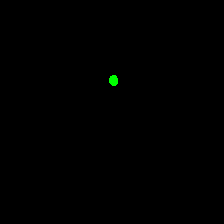

In [16]:
from google.colab.patches import cv2_imshow
image = t1.transpose((2,1,0)).astype(np.float32)
mask = t2.transpose((2,1,0)).astype(np.float32)
seg_img = image + (mask * 40)
# mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
cv2_imshow(mask * 255)

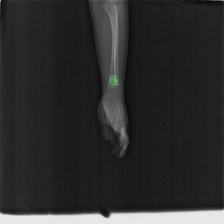

In [18]:
cv2_imshow(seg_img)

In [20]:
## Custom all in one Data_generator
class MyGen(Dataset):

    def __init__(self,
                 org_image_path = '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset100_FracAtles/imagesTr',
                 pred_masks_path =  '/content/content/MSD/Dataset100_FracAtles/data_masks',
                 meta_data = final_csv,
                 col_to_train=['fractured']):


        self.meta_data = meta_data


        self.select_cols = col_to_train

    def num_classes(self):
        return len(self.select_cols)

    def data_size(self):
        return self.meta_data.shape[0]

    def __len__(self):
        return self.meta_data.shape[0]


    def __getitem__(self, idx):

        # A path to a T1-weighted brain .nii image:
        org_img = org_image_path+ '/'+ self.meta_data['image_id'][idx]
        mask_img= pred_masks_path + '/' + self.meta_data['image_id'][idx][:-12] + '.nii.gz'
        # Read the .nii image containing the volume with SimpleITK:
        sitk_t1 = sitk.ReadImage(org_img)
        sitk_t2 = sitk.ReadImage(mask_img)
        # and access the numpy array:
        t1 = sitk.GetArrayFromImage(sitk_t1)
        t2 = sitk.GetArrayFromImage(sitk_t2)

        image = t1.transpose((2,1,0)).astype(np.float32)
        mask = t2.transpose((2,1,0)).astype(np.float32)
        seg_img = image + (mask * 40)

        seg_img = seg_img.transpose((2,0,1)).astype(np.float32)

        label = self.meta_data.loc[idx, self.select_cols].values.astype(np.float32)

        return seg_img, label


In [21]:
model = timm.create_model('resnet18', num_classes=1, pretrained=True)
model = model.cuda()

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [23]:
accuracy = evaluate.load("accuracy")

In [24]:
def compute_metrics(test_pred,test_true):
    predictions = test_pred
    labels = test_true
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc['accuracy']

In [25]:

trainGen = MyGen(meta_data = train_csv)

valGen =  MyGen(meta_data = valid_csv)

trainloader =  torch.utils.data.DataLoader(trainGen, batch_size=20, shuffle=True)
testloader =  torch.utils.data.DataLoader(valGen, batch_size=1, shuffle=False)

# define loss & optimizer
Loss = nn.BCELoss()

optimizer = Adam(model.parameters(), lr=1e-3)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay LR by a factor of 0.5 every 5 epochs

#model.load_state_dict(torch.load(load_weights_path))

# training
const_threshold = 5

val_acc = 0
best_acc = 0
const_cnt = 0

for epoch in range(5):

    for idx, data in enumerate(trainloader):
      train_data, train_labels = data
      train_data, train_labels  = train_data.cuda(), train_labels.cuda()
      y_pred = model(train_data)
      y_pred = torch.sigmoid(y_pred)
      loss = Loss(y_pred, train_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # validation
      if idx % 15 == 0:
         model.eval()
         with torch.no_grad():
              test_pred = []
              test_true = []
              for data in testloader:
                  test_data, test_labels = data
                  test_data = test_data.cuda()
                  y_pred = model(test_data)
                  y_pred = torch.sigmoid(y_pred)
                  y_pred = torch.round(y_pred)
                  test_pred.append(y_pred.cpu().detach().numpy())
                  test_true.append(test_labels.numpy())

              test_true = np.concatenate(test_true)
              test_pred = np.concatenate(test_pred)
              val_acc =  compute_metrics(test_pred, test_true)
              model.train()

              if best_acc < val_acc:
                  const_cnt = 0
                  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
                  best_acc = val_acc
                  torch.save(model.state_dict(), save_weights_path)
              else:
                  const_cnt += 1
                  scheduler.step()

              if (const_cnt > const_threshold):
                  const_cnt = 0
                  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
                  model.load_state_dict(torch.load(save_weights_path))

              lr = get_lr(optimizer)

              print ('Epoch=%s, BatchID=%s, Val_acc=%.4f, Best_Val_acc=%.4f, lr=%f' %(epoch, idx, val_acc, best_acc, lr))


Epoch=0, BatchID=0, Val_acc=0.4803, Best_Val_acc=0.4803, lr=0.001000
Epoch=0, BatchID=15, Val_acc=0.5395, Best_Val_acc=0.5395, lr=0.001000
Epoch=0, BatchID=30, Val_acc=0.6776, Best_Val_acc=0.6776, lr=0.001000
Epoch=0, BatchID=45, Val_acc=0.7829, Best_Val_acc=0.7829, lr=0.001000
Epoch=0, BatchID=60, Val_acc=0.7632, Best_Val_acc=0.7829, lr=0.001000
Epoch=1, BatchID=0, Val_acc=0.6118, Best_Val_acc=0.7829, lr=0.001000
Epoch=1, BatchID=15, Val_acc=0.7763, Best_Val_acc=0.7829, lr=0.001000
Epoch=1, BatchID=30, Val_acc=0.6908, Best_Val_acc=0.7829, lr=0.001000
Epoch=1, BatchID=45, Val_acc=0.7105, Best_Val_acc=0.7829, lr=0.000500
Epoch=1, BatchID=60, Val_acc=0.6776, Best_Val_acc=0.7829, lr=0.000500
Epoch=2, BatchID=0, Val_acc=0.7763, Best_Val_acc=0.7829, lr=0.000500
Epoch=2, BatchID=15, Val_acc=0.7829, Best_Val_acc=0.7829, lr=0.000500
Epoch=2, BatchID=30, Val_acc=0.8026, Best_Val_acc=0.8026, lr=0.000500
Epoch=2, BatchID=45, Val_acc=0.7763, Best_Val_acc=0.8026, lr=0.000500
Epoch=2, BatchID=60, Va